# Transfer Learning for Image Classification

## Project Overview

This project explores transfer learning for a 9-class image classification task.
We evaluate multiple pretrained architectures, experiment with augmentation
pipelines, analyze model errors, and introduce targeted regularization strategies
to reduce overfitting and improve generalization.

## Project Objectives

- Implement and compare multiple pre-trained CNN architectures for image classification
- Evaluate the effectiveness of transfer learning on a small, domain-specific dataset
- Conduct comprehensive error analysis to identify model weaknesses
- Experiment with data augmentation strategies to improve generalization
- Optimize model performance through hyperparameter tuning and architecture selection

## Key Achievements

- **Best Validation Accuracy**: 90% using Wide ResNet-50-2 architecture
- **Architectures Tested**: 7 different pre-trained models (VGG16, ResNet18, DenseNet161, GoogleNet, MobileNet-v2, ResNeXt50, Wide ResNet-50-2)
- **Comprehensive Analysis**: Model convergence visualization, confusion matrices, error pattern analysis
- **Data Augmentation**: Multiple augmentation strategies tested and optimized

## Methodology

This project employs **transfer learning** - a technique where a model pre-trained on a large dataset (ImageNet) is fine-tuned for a specific task. The approach involves:
1. **Fine-tuning**: Initializing the network with pre-trained weights and training all layers with a lower learning rate
2. **Architecture Adaptation**: Replacing the final classification layer to match the target task (9 classes instead of 1000)

## Dataset

- **Task**: Multi-class image classification
- **Classes**: 9 Israeli politicians
- **Training Images**: ~929 images (~100 per class)
- **Validation Images**: ~234 images
- **Challenge**: Small dataset size requires transfer learning for effective generalization


## Setup and Environment

**Note**: This project was developed using PyTorch and can be run on Google Colab with GPU support for faster training. The implementation is based on PyTorch's transfer learning tutorial, adapted and extended for this specific classification task



## 1. Setup and Imports

Import all necessary libraries and configure the environment for the project.

In [1]:
# %%bash
# # Install all Python dependencies (quiet mode)

# pip install -q --upgrade pip setuptools wheel

# pip install -q \
#     torch \
#     torchvision \
#     torchaudio \
#     matplotlib \
#     seaborn \
#     pandas \
#     numpy \
#     scikit-learn \
#     scikit-image \
#     pillow \
#     tqdm \
#     torchsummary \
#     ipykernel

# echo "All dependencies installed."


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
plt.ion()  # Enable interactive mode for matplotlib

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from typing import Dict, Optional, Tuple, List

In [5]:
# Training hyperparameters
DEFAULT_LEARNING_RATE = 0.001
DEFAULT_MOMENTUM = 0.9
DEFAULT_WEIGHT_DECAY = 1e-4
DEFAULT_NUM_EPOCHS = 50

# Learning rate scheduler parameters
DEFAULT_STEP_SIZE = 7
DEFAULT_GAMMA = 0.1

# Data loading parameters
DEFAULT_BATCH_SIZE = 16
DEFAULT_NUM_WORKERS = 4
IMAGE_SIZE = (256, 256)

# Model parameters
NUM_CLASSES = 9

# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

## 2. Data Loading and Preprocessing

### Dataset Description

**Project Objective**: Classify images of Israeli politicians into 9 distinct categories.

**Dataset Characteristics**:
- **Classes**: 9 Israeli politicians
- **Training Images**: ~100 images per class (total ~929 images)
- **Validation Images**: ~234 images
- **Data Source**: Images automatically scraped from Google Images Search (first page results, no manual curation)

**Challenge**: This is a small dataset that would typically struggle to generalize if trained from scratch. Transfer learning allows us to leverage features learned from large-scale datasets (ImageNet) to achieve good performance despite limited training data.

In [6]:
# Create directories for dataset storage
!mkdir -p data/israeli_politicians

In [7]:
# Download our dataset and extract it
import requests
from zipfile import ZipFile

url = 'https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('./data/israeli_politicians.zip', 'wb').write(r.content)

with ZipFile('./data/israeli_politicians.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='./data/israeli_politicians/')

In [8]:
# On Linux 
# !wget https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true
# !unzip israeli_politicians.zip -d data/israeli_politicians/

### Dataset Exploration

Before training, it's important to understand the dataset characteristics. Key aspects to examine include:
- Image quality and consistency
- Potential biases or data quality issues
- Class distribution and balance
- Factors that might affect model generalization

### Data Pipeline Implementation

**Data Transformations**: Images are resized to 256x256 pixels and normalized using ImageNet statistics (mean and standard deviation) to match the pre-trained models' expected input format.

In [9]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

In [10]:
data_dir = r'./data/israeli_politicians/'

# Create a dictionary of train and val datasets from images in folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

A data loader wraps an iterable around the Dataset to enable easy access to the samples. It combines a dataset and a sampler.

In [11]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=DEFAULT_BATCH_SIZE,
                                             shuffle=True, num_workers=DEFAULT_NUM_WORKERS),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=DEFAULT_BATCH_SIZE,
                                          shuffle=False, num_workers=DEFAULT_NUM_WORKERS)
  }

In [12]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

class_names = image_datasets['train'].classes
print('class_names:', class_names)

dataset_sizes:  {'train': 929, 'val': 234}
class_names: ['ayelet_shaked', 'benjamin_netanyahu', 'benny_gantz', 'danny_danon', 'gideon_saar', 'kostya_kilimnik', 'naftali_bennett', 'ofir_akunis', 'yair_lapid']


In [13]:
# Check for the availability of a GPU, and use CPU otherwise
# If you are using Google Colab, be sure to change your runtime environment to GPU first.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Dataset and DataLoader Attributes

Checking structure and available attributes for data inspection and manipulation.  

In [14]:
train_dataloader = dataloaders['train']
train_dataloader.dataset.class_to_idx

{'ayelet_shaked': 0,
 'benjamin_netanyahu': 1,
 'benny_gantz': 2,
 'danny_danon': 3,
 'gideon_saar': 4,
 'kostya_kilimnik': 5,
 'naftali_bennett': 6,
 'ofir_akunis': 7,
 'yair_lapid': 8}

### Data Visualization

Sample training images are visualized to verify data loading and understand the preprocessing transformations applied to the dataset.



In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stds)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [16]:
inputs, classes = next(iter(dataloaders['train']))

To map it to the class names, we can run:

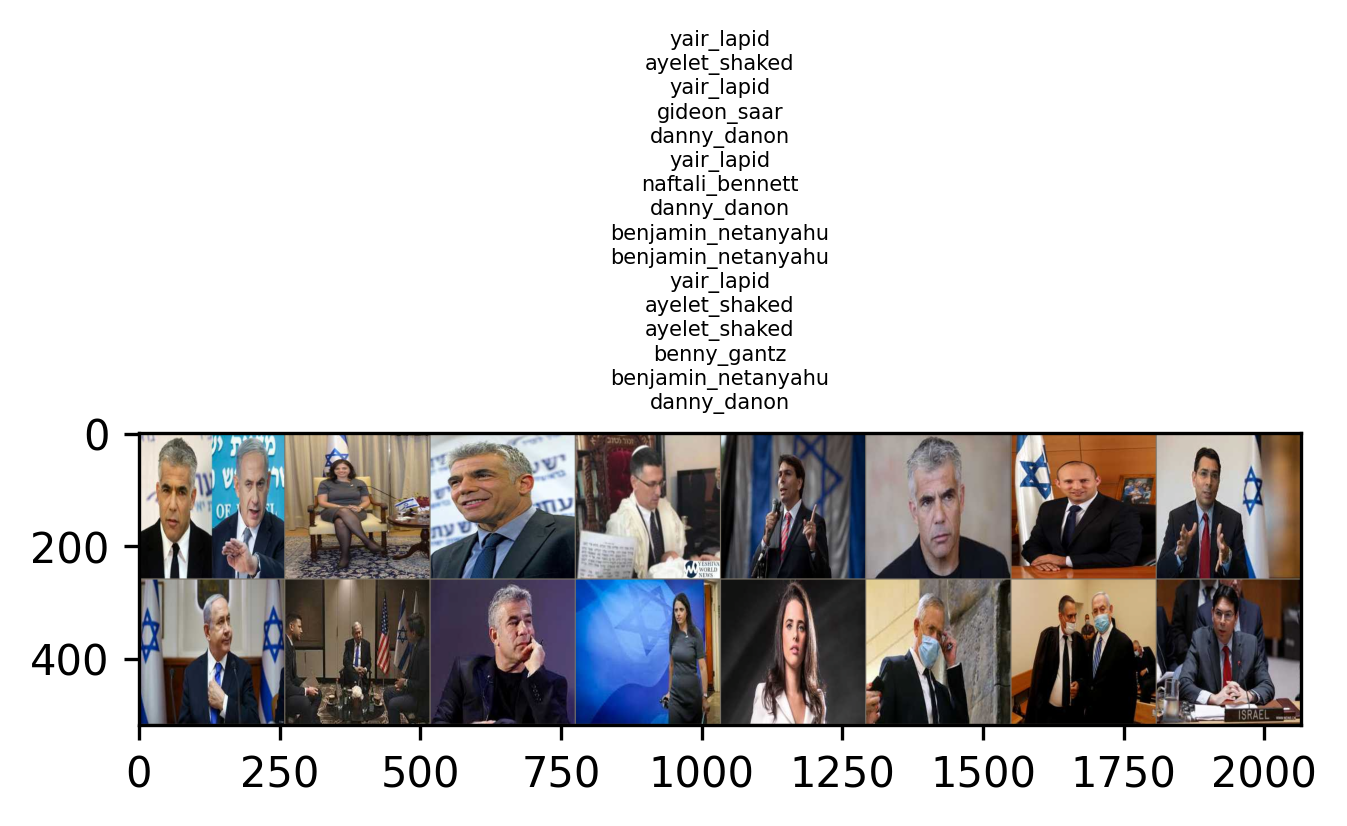

In [17]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

imshow(out, title='\n'.join([class_names[x] for x in classes]))

### Using a pretrained model
Loading a model pretrained on ImageNet, VGG16 network, that won the ImageNet Challenge in 2016

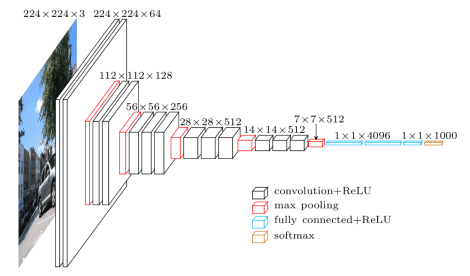

In [18]:
from IPython import display
display.Image("https://viso.ai/wp-content/uploads/2021/10/vgg-neural-network-architecture.png")

The first time the model is loaded, it is downloaded locally and then cached for future use.

In [19]:
model = models.vgg16(pretrained=True)

The model structure can be printed to examine its architecture as shown below. The model is composed of 2D Convolution layers, non-linear ReLU activation, and 2D Max pooling, followed by a few fully connected layers.

In [20]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Keras has a useful model summary, that we can also use for PyTorch models:

In [21]:
from torchsummary import summary
summary(model.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

We can see above that the final layer is a fully connected layer, from 4096 neurons to 1000 neurons, with a total of `4096 * 1000 + 1000 = 4,097,000` parameters. We add 1000 weights for the bias term of each output neuron.  

So in total, VGG-16 has 138M parameters, and we've set them all to be trainable.

However, VGG-16 and other networks created for ImageNet all have 1,000 neurons in their output, since they classify images to one of the 1,000 categories in the ImageNet challenge.  
To use the network for our task, we need to replace the final fully-connected layer with one mapping to 9 neurons instead of 1000:

In [22]:
# This code should output the number of input neurons to the final layer. We'll use it to create a new layer instead of it.
last_layer = list(model.children())[-1]
if hasattr(last_layer, 'in_features'):
  num_ftrs = last_layer.in_features
else:
  num_ftrs = last_layer[-1].in_features

num_ftrs

4096

The final layer is `model.classifier[6]`.

In [23]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

We replace the final layer with a linear layer mapping from 4096 input features (the feature dimension from the previous layer) to 9 output features (one for each politician class):

In [24]:
model.classifier[6] = nn.Linear(in_features=num_ftrs, out_features=NUM_CLASSES)

### Model Architecture Verification

Verifying updated model architecture



In [25]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
summary(model.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Next, lets define the loss, optimizer and LR scheduler.

In [27]:
model = model.to(device)

# For a multi-class problem, usually using CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent as DEFAULT the optimizer, with a learning rate of 0.001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=DEFAULT_LEARNING_RATE, momentum=DEFAULT_MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=DEFAULT_STEP_SIZE, gamma=DEFAULT_GAMMA)

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [28]:

def plot_loss_accuracy(losses, accuracies):
    """
    Plot training/validation loss and accuracy curves.
    """
    sns.set(style="whitegrid")

    for dictionary, name in zip([losses, accuracies], ['Loss', 'Accuracy']):
        plt.figure(figsize=(10, 8))


        for key, value in dictionary.items():
            x_values = range(len(value))
            plt.plot(x_values, value, label=key, marker='o')

            # annotate points
            for x, y in zip(x_values, value):
                plt.text(x, y, f'{y:.3f}', fontsize=10, ha='right', va='bottom')

        plt.title(f'{name} over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_performance(performance, validation_labels, true_labels):
    """
    Plot confusion matrices, epoch time, and per-label accuracy.
    """
    for phase in ['train', 'val']:
        validation_labels_flat = np.concatenate(
            [label.cpu().numpy() for label in validation_labels[phase]]
        )
        true_labels_flat = np.concatenate(
            [label.cpu().numpy() for label in true_labels[phase]]
        )

        cm = confusion_matrix(true_labels_flat, validation_labels_flat)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix for {phase}")
        plt.show()


    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(performance)), performance, marker='o')
    plt.title("Time per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.tight_layout()
    plt.show()

    print("Accuracy of the validation test per label")

    phase = "val"
    validation_labels_flat = np.concatenate(
        [label.cpu().numpy() for label in validation_labels[phase]]
    )
    true_labels_flat = np.concatenate(
        [label.cpu().numpy() for label in true_labels[phase]]
    )

    df = pd.DataFrame({'val': validation_labels_flat, 'true': true_labels_flat})
    total_counts = df.groupby('true').size()
    match_counts = df[df['true'] == df['val']].groupby('true').size()
    match_percentage = (match_counts / total_counts * 100).fillna(0)

    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        x=match_percentage.index,
        y=match_percentage.values,
        palette="Blues"
    )

    for i, (percentage, total) in enumerate(zip(match_percentage, total_counts)):
        ax.text(i, percentage + 1, f"{percentage:.1f}%\n(Total: {total})",
                ha='center', fontsize=12)

    plt.xlabel("True Labels")
    plt.ylabel("Match Percentage")
    plt.title("Percentage of Correct Predictions per Label")
    plt.ylim(0, 100)
    plt.show()

def train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
    plot_convergence=False,
    plot_epoch_performance=False
):
    """
    Train a PyTorch model and return predictions, probabilities,
    ground truth labels, and best validation accuracy.

    Returns:
        model: model with best validation weights loaded
        best_acc: best validation accuracy (float)
        validation_labels: dict of predicted class tensors
        probabilities: dict of raw model output tensors (logits)
        true_labels: dict of ground truth class tensors
    """

    since = time.time()

    # stores
    validation_labels = {'train': [], 'val': []}
    probabilities = {'train': [], 'val': []}
    true_labels = {'train': [], 'val': []}

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    performance_timing = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)

        epoch_start = time.time()

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # store predictions/probabilities/labels
                    validation_labels[phase].append(preds.detach().cpu())
                    probabilities[phase].append(outputs.detach().cpu())
                    true_labels[phase].append(labels.detach().cpu())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # track best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        performance_timing.append(time.time() - epoch_start)
        print()

    # summary
    time_elapsed = time.time() - since
    print(f"Training complete in {int(time_elapsed//60)}m {int(time_elapsed%60)}s")
    print(f"Best val Acc: {best_acc:.6f}")

    # load best weights
    model.load_state_dict(best_model_wts)

    # optional plots
    if plot_convergence:
        plot_loss_accuracy(losses, accuracies)

    if plot_epoch_performance:
        plot_performance(performance_timing, validation_labels, true_labels)

    return model, best_acc, validation_labels, probabilities, true_labels


## Finetuning the network




### Initial train and evaluate

Epoch 0/24
----------
train Loss: 1.8842 Acc: 0.3272
val Loss: 1.4532 Acc: 0.4487

Epoch 1/24
----------
train Loss: 1.0787 Acc: 0.6114
val Loss: 1.0532 Acc: 0.6667

Epoch 2/24
----------
train Loss: 0.6857 Acc: 0.7675
val Loss: 0.9722 Acc: 0.7051

Epoch 3/24
----------
train Loss: 0.5257 Acc: 0.8310
val Loss: 0.9309 Acc: 0.6966

Epoch 4/24
----------
train Loss: 0.4193 Acc: 0.8784
val Loss: 0.7939 Acc: 0.7650

Epoch 5/24
----------
train Loss: 0.1209 Acc: 0.9699
val Loss: 0.7475 Acc: 0.7692

Epoch 6/24
----------
train Loss: 0.0744 Acc: 0.9828
val Loss: 0.7326 Acc: 0.7991

Epoch 7/24
----------
train Loss: 0.0250 Acc: 0.9957
val Loss: 0.7236 Acc: 0.8120

Epoch 8/24
----------
train Loss: 0.0162 Acc: 0.9968
val Loss: 0.7337 Acc: 0.8205

Epoch 9/24
----------
train Loss: 0.0160 Acc: 0.9946
val Loss: 0.7295 Acc: 0.8120

Epoch 10/24
----------
train Loss: 0.0255 Acc: 0.9957
val Loss: 0.7406 Acc: 0.8120

Epoch 11/24
----------
train Loss: 0.0152 Acc: 0.9946
val Loss: 0.7574 Acc: 0.8077

Ep

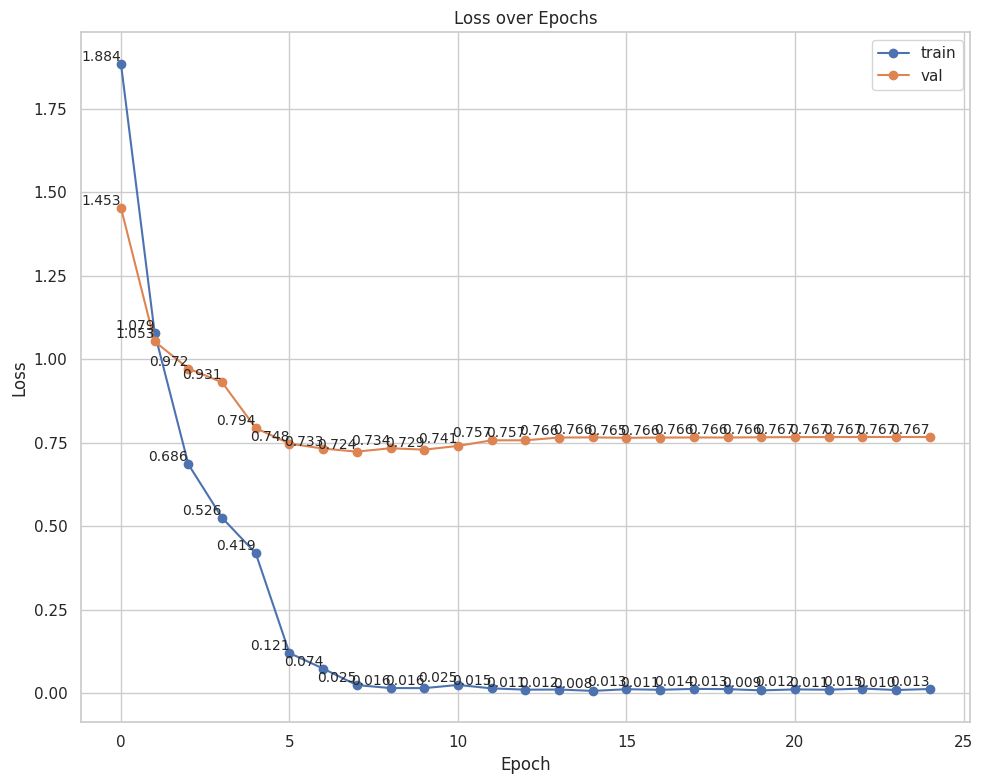

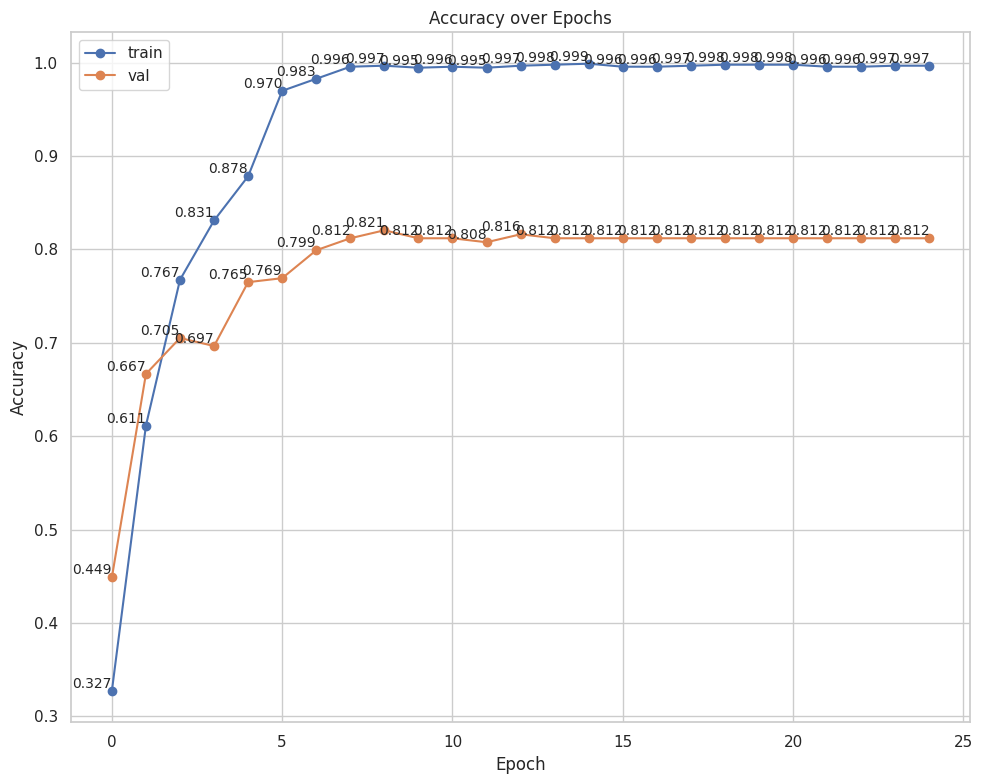

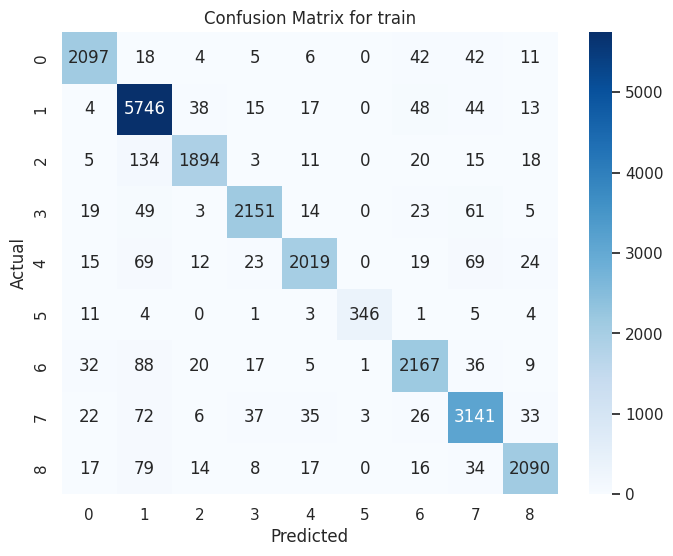

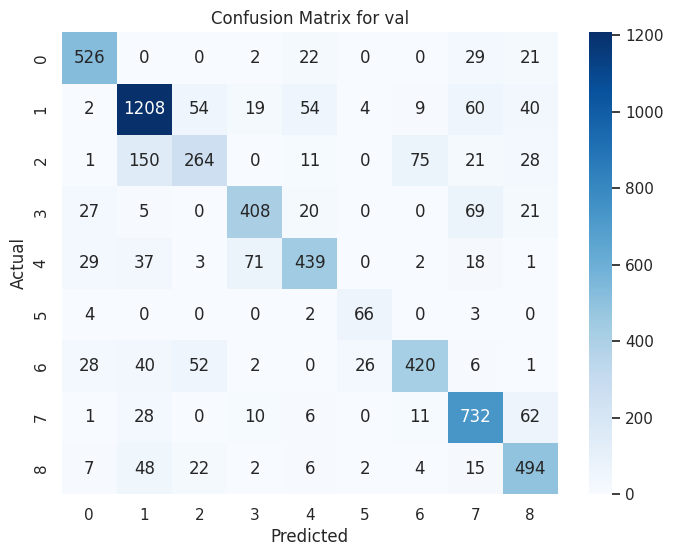

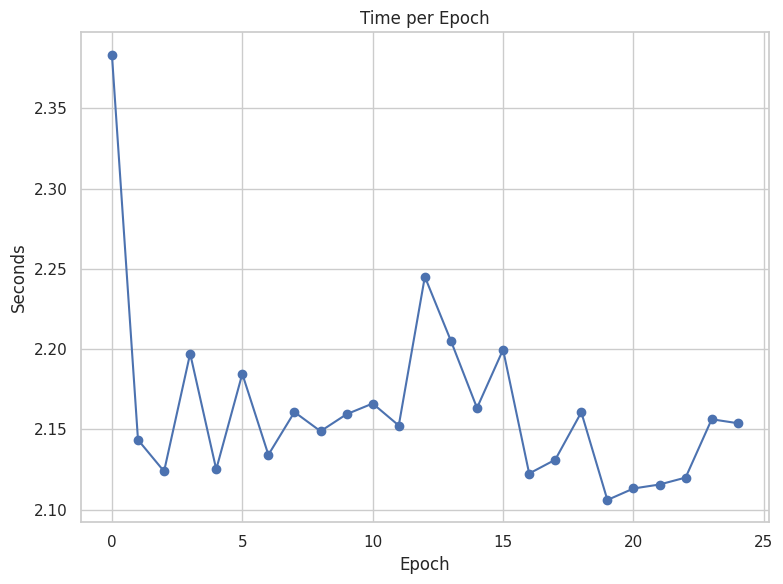

Accuracy of the validation test per label


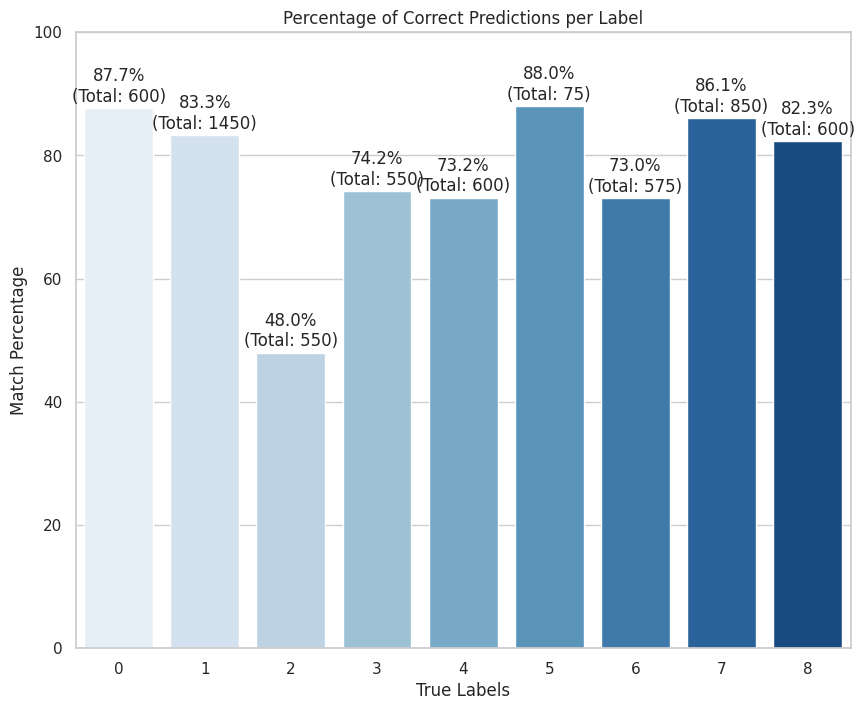

In [29]:
model, best_acc, validation_labels, probabilities, true_labels = train_model(model,
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       plot_convergence=True,
                       plot_epoch_performance=True)

## Initial Conclusion

The model shows clear overfitting, and it happens very early in training.
By epoch 3–4, the training accuracy is already above 90%, while the validation accuracy fluctuates and does not improve consistently. By epoch 8–10, the gap becomes stable:

* Training accuracy: climbs toward 99–100%
* Validation accuracy: plateaus around 0.82–0.83
* Validation loss: stops decreasing and then slightly increases

Model is learning the training set too well while failing to generalize, which is further supported by the confusion matrices: the training predictions are extremely sharp and diagonal, while the validation set shows several classes with high confusion.

We can also see that some classes are performing much worse than others, like 2 and 6. This needs to be investigated 

This is a start, but we have many ways to improve generalization:

* early stopping to prevent unnecessary over-training

* stronger or better-targeted augmentation

* adding dropout or weight decay for regularization

* adjusting the learning rate schedule (e.g., ReduceLROnPlateau)

* unfreezing more layers or fine-tuning differently

Before that, lets visualize results and do some error analysis 

### Model Prediction Visualization

A function is implemented to visualize model predictions on sample images, allowing for qualitative assessment of model performance and identification of potential issues.




## Intuition:
* we see that the class with most accurate results is the one with the least amount of images, that may be the reason for its success, while when looking at the class with most inaccurate lableling, our results show multiple people present on the image, that may get the model confused

## Error Analysis
Error Analysis is an extremely important practice in Machine Learning research. It is rare that our base model works great out of the box. Proper error analysis helps us detect and fix issues in our DL code, data preprocessing and even in the data itself.

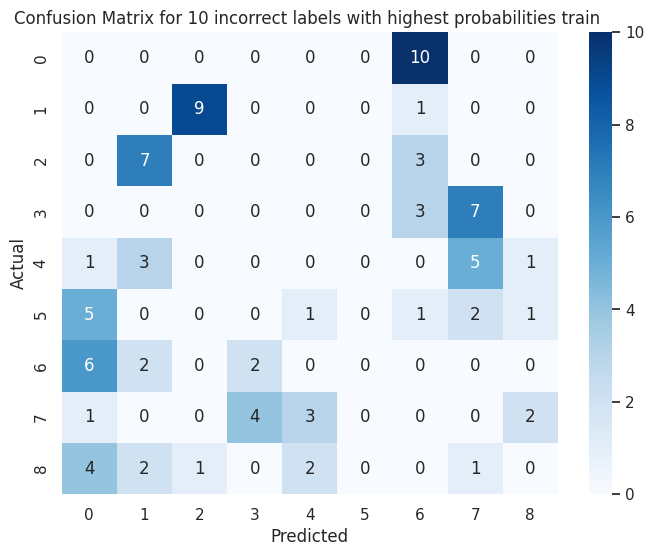

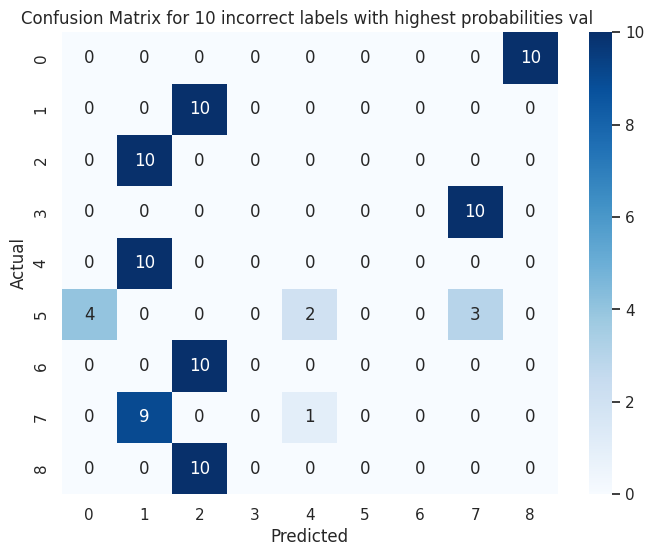

In [32]:

def plot_cm_top_10(validation_labels, probabilities, true_labels):
  for phase in ['train', 'val']:
    validation_labels_flat = np.concatenate([label.cpu().numpy() for label in validation_labels[phase]])
    if phase == 'train':
      probabiliies_flat = np.concatenate([torch.max(pr, 1)[0].cpu().detach().numpy() for pr in probabilities['train']])
    elif phase == 'val':
      probabiliies_flat = np.concatenate([torch.max(pr, 1)[0].cpu().numpy() for pr in probabilities[phase]])
    true_labels_flat = np.concatenate([label.cpu().numpy() for label in true_labels[phase]])
    df = pd.DataFrame({'val': validation_labels_flat, 'prob': probabiliies_flat, 'true': true_labels_flat})
    top_10 = (
        df[df['val'] != df['true']].groupby('true')
        .apply(lambda x: x.nlargest(10, 'prob'))
        .reset_index(drop=True)
    )
    cm = confusion_matrix( top_10['true'], top_10['val'],)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for 10 incorrect labels with highest probabilities {phase} ')
    plt.show()

plot_cm_top_10(validation_labels, probabilities, true_labels)


### Train Set
In the training set, confident mistakes appear across several classes. Even though the model almost memorizes the training data (very high training accuracy), it still produces a small number of high-confidence confusions. This suggests that certain identities remain difficult even during overfitting, likely due to:
* strong visual similarity between specific individuals,
* variations in pose, lighting, or angle,
* or insufficient intra-class diversity for some labels.
This confirms that the model has not learned fully separable boundaries for all classes.
### Validation Set

In the validation set, the pattern becomes clearer:
* Several classes consistently appear among the top high-confidence mistakes.
* The misclassifications are systematic, not random.
* Certain class pairs are repeatedly confused with high certainty.

This behavior matches earlier indicators of overfitting:
the model fits the training data extremely well but fails to generalize cleanly to unseen samples, leading to confidently wrong predictions on specific identities.

### Overall 

The model’s hardest confusions are clustered between specific class pairs, not spread randomly.
Improving generalization will require focusing on these identity pairs—either through additional training images, targeted augmentation, or better regularization.

### Augmentation Experiment Overview

To understand how different data augmentation strategies affect generalization, we train a fresh VGG16 model
from ImageNet weights for each transformation configuration. For every run we:

- Apply a specific augmentation pipeline on the training set
- Keep the validation preprocessing fixed (resize + normalization)
- Train with the same optimizer, learning rate schedule, and number of epochs
- Collect validation predictions, probabilities, and true labels
- Compute overall validation accuracy and store diagnostics for deeper error analysis

This turns the augmentation section into a small, self-contained experiment that can be shown as a portfolio piece,
highlighting not only model training but also experimental design and interpretation.


### Data Augmentation Strategies

Data augmentation is a powerful technique to increase the effective size of the training dataset without manual labeling. By applying transformations to existing images, we create additional training examples that help the model generalize better.

### Augmentation Techniques Explored

Various augmentation strategies are experimented with using `torchvision.transforms`:

- **Geometric Transformations**: Random flips, rotations, affine transformations
- **Color Jittering**: Brightness, contrast adjustments
- **Noise Injection**: Gaussian noise for robustness
- **Combination Strategies**: Testing different combinations of augmentations

Each strategy is evaluated to determine its impact on validation accuracy and generalization. The goal is to find augmentation strategies that improve model performance without introducing artifacts that degrade image quality.

**Reference**: [Image Augmentation Guide](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)

In [33]:
from skimage.util import random_noise
from PIL import Image

def add_random_noise(img, mode='gaussian', var=0.01):
    img = np.array(img) / 255.0  # Normalize to [0,1] for skimage
    noisy_img = random_noise(img, mode=mode, var=var)  # Add noise
    noisy_img = (noisy_img * 255).astype(np.uint8)  # Convert back to [0,255]
    return Image.fromarray(noisy_img)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

data_transforms_aug_strong = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(45),
        transforms.RandomAffine(0, translate=(0.25, 0.25)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.Lambda(lambda img: add_random_noise(img, mode='gaussian', var=0.01)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),

    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

data_transforms_aug_moderate = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.Lambda(lambda img: add_random_noise(img, mode='gaussian', var=0.01)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),

    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

data_transforms_aug_fewer_transformations = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.RandomAffine(0, translate=(0.25, 0.25)),
        transforms.Lambda(lambda img: add_random_noise(img, mode='gaussian', var=0.01)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),

    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}


data_transforms_aug_simple_transformations = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),

    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    }
data_transforms_rotate = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),

    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

data_transforms_horizontal= {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),

    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

data_transforms_affine = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),

    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

In [36]:
def transform_and_train(data_transforms_function, name, num_epochs=25):
    """
    Run a single augmentation experiment with VGG16 and return
    validation accuracy and diagnostics for further analysis.
    """
    print("=" * 80)
    print(f"Experiment: {name}")
    print("=" * 80)

    model = models.vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=9)
    model = model.to(device)

    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    image_datasets = {
        x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_function[x])
        for x in ['train', 'val']
    }
    dataloaders = {
        x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
        for x in ['train', 'val']
    }

    global dataset_sizes
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    model, best_acc, validation_labels, probabilities, true_labels = train_model(
        model,
        dataloaders,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        num_epochs=num_epochs,
        plot_convergence=False,
        plot_epoch_performance=False,
    )

    val_preds = np.concatenate([p.cpu().numpy() for p in validation_labels['val']])
    val_true = np.concatenate([t.cpu().numpy() for t in true_labels['val']])
    val_acc = (val_preds == val_true).mean()

    print(f"Final validation accuracy for {name}: {val_acc:.4f}")
    print("*" * 80)

    return {
        'name': name,
        'model': model,
        'val_accuracy': val_acc,
        'validation_labels': validation_labels,
        'probabilities': probabilities,
        'true_labels': true_labels,
    }


In [37]:
# Run a suite of augmentation experiments and compare validation accuracy
augment_configs = [
    ('standard transformation', data_transforms),
    ('transformation with strong changes', data_transforms_aug_strong),
    ('transformation with moderate changes', data_transforms_aug_moderate),
    ('fewer transformations', data_transforms_aug_fewer_transformations),
    ('basic moderate transformations', data_transforms_aug_simple_transformations),
    ('horizontal flip', data_transforms_horizontal),
    ('affine', data_transforms_affine),
    ('rotate', data_transforms_rotate),
]

augmentation_results = []
augmentation_artifacts = {}

for name, transforms_cfg in augment_configs:
    result = transform_and_train(transforms_cfg, name)
    augmentation_results.append({'Augmentation': name, 'Val Accuracy': result['val_accuracy']})
    augmentation_artifacts[name] = result

augmentation_results_df = pd.DataFrame(augmentation_results)
augmentation_results_df = augmentation_results_df.sort_values('Val Accuracy', ascending=False).reset_index(drop=True)
augmentation_results_df

Experiment: standard transformation
Epoch 0/24
----------
train Loss: 1.7656 Acc: 0.3520
val Loss: 1.4231 Acc: 0.5128

Epoch 1/24
----------
train Loss: 1.2094 Acc: 0.5770
val Loss: 1.2288 Acc: 0.5726

Epoch 2/24
----------
train Loss: 0.8148 Acc: 0.7298
val Loss: 1.2082 Acc: 0.6154

Epoch 3/24
----------
train Loss: 0.6189 Acc: 0.8105
val Loss: 0.7564 Acc: 0.7821

Epoch 4/24
----------
train Loss: 0.4291 Acc: 0.8633
val Loss: 0.8689 Acc: 0.7436

Epoch 5/24
----------
train Loss: 0.3520 Acc: 0.9031
val Loss: 0.7495 Acc: 0.7863

Epoch 6/24
----------
train Loss: 0.1176 Acc: 0.9602
val Loss: 0.8541 Acc: 0.7735

Epoch 7/24
----------
train Loss: 0.0921 Acc: 0.9785
val Loss: 0.7241 Acc: 0.8034

Epoch 8/24
----------
train Loss: 0.1011 Acc: 0.9795
val Loss: 0.7371 Acc: 0.7906

Epoch 9/24
----------
train Loss: 0.0474 Acc: 0.9892
val Loss: 0.7303 Acc: 0.8205

Epoch 10/24
----------
train Loss: 0.0374 Acc: 0.9935
val Loss: 0.7405 Acc: 0.8162

Epoch 11/24
----------
train Loss: 0.0450 Acc: 0.9

,Augmentation,Val Accuracy
0,affine,0.801368
1,rotate,0.789402
2,horizontal flip,0.780513
3,standard transformation,0.777436
4,basic moderate transformations,0.750940
5,fewer transformations,0.678803
6,transformation with moderate changes,0.550598
7,transformation with strong changes,0.490940


evaluating multiple augmentation strategies, the results show a consistent pattern:
* Heavier augmentations harm performance,
* Mild or simple augmentations help,
* The best accuracy comes from light, single-transform augmentations

So we're gonna use light augmentations as default:
* RandomRotation(20)
* RandomHorizontalFlip(p=0.5)
* mild Affine(translate)
* standard normalization

So we would go with

In [38]:
data_transforms_light = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),

    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}


## Different Model Architectures


In the code above we've used the `VGG` architecture. Now lets try to increase model performance by using alternative architectures from [torchvision.models](https://pytorch.org/vision/0.8/models.html).  

In [40]:
model_names = [
    'vgg16', 
    'resnet18',
    'densenet161', 
    'googlenet', 
    'mobilenet_v2', 
    'resnext50_32x4d', 
    'wide_resnet50_2'
]

model_results = []

for model_name in model_names:
    print("=" * 70)
    print(f"Training model: {model_name}")
    print("=" * 70)

    # Load pretrained model
    model = getattr(models, model_name)(pretrained=True)

    # Adjust last layer depending on architecture
    if model_name.startswith("vgg") or model_name.startswith("mobilenet"):
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, 9)

    elif model_name.startswith(("resnet", "resnext", "wide_resnet")):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 9)

    elif model_name.startswith("densenet"):
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 9)

    elif model_name.startswith("googlenet"):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 9)
        if model.aux_logits:
            model.aux1.fc = nn.Linear(model.aux1.fc.in_features, 9)
            model.aux2.fc = nn.Linear(model.aux2.fc.in_features, 9)

    model = model.to(device)

    # Optimizer + scheduler
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    # Datasets
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x),
            data_transforms[x]
        )
        for x in ['train', 'val']
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x],
            batch_size=16,
            shuffle=True,
            num_workers=4
        )
        for x in ['train', 'val']
    }

    # Update dataset sizes global
    dataset_sizes = {
        x: len(image_datasets[x])
        for x in ['train', 'val']
    }

    # Train the model
    model, best_acc, val_labels, probs, true_labels = train_model(
        model,
        dataloaders,
        criterion,
        optimizer_ft,
        exp_lr_scheduler
    )

    # Save results
    model_results.append((model_name, float(best_acc)))

    print(f"Finished {model_name}. Best Acc = {best_acc:.4f}")
    print("*" * 50)

# Convert results to table
import pandas as pd
df_results = pd.DataFrame(model_results, columns=['Model', 'Val Accuracy'])

print("\n\n=== Final Model Comparison ===")
print(df_results)

Training model: vgg16
Epoch 0/24
----------
train Loss: 1.7864 Acc: 0.3681
val Loss: 1.6673 Acc: 0.3932

Epoch 1/24
----------
train Loss: 1.1808 Acc: 0.5780
val Loss: 1.0668 Acc: 0.6197

Epoch 2/24
----------
train Loss: 0.7526 Acc: 0.7524
val Loss: 0.8089 Acc: 0.7222

Epoch 3/24
----------
train Loss: 0.4534 Acc: 0.8525
val Loss: 0.8428 Acc: 0.7564

Epoch 4/24
----------
train Loss: 0.3756 Acc: 0.8891
val Loss: 0.9966 Acc: 0.7265

Epoch 5/24
----------
train Loss: 0.2957 Acc: 0.9085
val Loss: 0.6650 Acc: 0.7863

Epoch 6/24
----------
train Loss: 0.1410 Acc: 0.9602
val Loss: 0.7731 Acc: 0.7821

Epoch 7/24
----------
train Loss: 0.1134 Acc: 0.9699
val Loss: 0.5936 Acc: 0.8333

Epoch 8/24
----------
train Loss: 0.0476 Acc: 0.9892
val Loss: 0.6095 Acc: 0.8291

Epoch 9/24
----------
train Loss: 0.0436 Acc: 0.9849
val Loss: 0.6225 Acc: 0.8248

Epoch 10/24
----------
train Loss: 0.0255 Acc: 0.9957
val Loss: 0.6663 Acc: 0.8205

Epoch 11/24
----------
train Loss: 0.0268 Acc: 0.9935
val Loss: 

We're gonna go with ResNeXt50 cause it's shows consistently good results

In [43]:
from torchvision import models
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, OneCycleLR

results = []

def prepare_resnext50(num_classes=9):
    model = models.resnext50_32x4d(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

def run_experiment(name, optimizer, scheduler):
    print(f"\n=== Running: {name} ===")
    model, best_acc, _, _, _ = train_model(
        model=optimizer.param_groups[0]['params'][0].grad_fn.__self__.model,  # replaced below
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=25,
        plot_convergence=False,
        plot_epoch_performance=False
    )
    return best_acc


model = prepare_resnext50()
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

model_exp1, best_acc1, _, _, _ = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25
)

results.append(("SGD + StepLR", float(best_acc1)))

model = prepare_resnext50()
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)

model_exp2, best_acc2, _, _, _ = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25
)

results.append(("AdamW + CosineAnnealing", float(best_acc2)))

model = prepare_resnext50()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=25,
    steps_per_epoch=len(dataloaders["train"])
)

model_exp3, best_acc3, _, _, _ = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25
)

results.append(("AdamW + OneCycleLR", float(best_acc3)))

df_results = pd.DataFrame(results, columns=["Experiment", "Val Accuracy"])
print("\n=== FINAL RESULTS ===")
print(df_results)

Epoch 0/24
----------
train Loss: 1.8187 Acc: 0.3402
val Loss: 1.4755 Acc: 0.4786

Epoch 1/24
----------
train Loss: 0.9419 Acc: 0.7330
val Loss: 0.7956 Acc: 0.7350

Epoch 2/24
----------
train Loss: 0.4503 Acc: 0.8751
val Loss: 0.6228 Acc: 0.7863

Epoch 3/24
----------
train Loss: 0.2232 Acc: 0.9451
val Loss: 0.5079 Acc: 0.8419

Epoch 4/24
----------
train Loss: 0.1326 Acc: 0.9817
val Loss: 0.4805 Acc: 0.8504

Epoch 5/24
----------
train Loss: 0.0871 Acc: 0.9871
val Loss: 0.4885 Acc: 0.8590

Epoch 6/24
----------
train Loss: 0.0637 Acc: 0.9892
val Loss: 0.4787 Acc: 0.8718

Epoch 7/24
----------
train Loss: 0.0373 Acc: 0.9925
val Loss: 0.4761 Acc: 0.8333

Epoch 8/24
----------
train Loss: 0.0404 Acc: 0.9935
val Loss: 0.4611 Acc: 0.8547

Epoch 9/24
----------
train Loss: 0.0338 Acc: 0.9968
val Loss: 0.4966 Acc: 0.8419

Epoch 10/24
----------
train Loss: 0.0320 Acc: 0.9946
val Loss: 0.4522 Acc: 0.8675

Epoch 11/24
----------
train Loss: 0.0428 Acc: 0.9914
val Loss: 0.4509 Acc: 0.8675

Ep

In [49]:
df_results

,Experiment,Val Accuracy
0,SGD + StepLR,0.876068
1,AdamW + CosineAnnealing,0.893162
2,AdamW + OneCycleLR,0.880342


Now let's use the best model and optimizer/scheduler with the augmentations while specifying on problematic classes

## Augmentation of problematic classes

In [44]:
very_hard_classes = [2]      # strongest augmentation
hard_confidence_classes = [4, 6]   # strong augmentation


# Strong augmentation (for classes 4 and 6)
strong_aug = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(18),
    transforms.RandomAffine(0, translate=(0.15, 0.15)),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

# Very strong augmentation (for class 2)
very_strong_aug = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(22),
    transforms.RandomAffine(0, translate=(0.20, 0.20)),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])


In [45]:
class_to_transform = {}

for cls in very_hard_classes:
    class_to_transform[cls] = very_strong_aug

for cls in hard_confidence_classes:
    class_to_transform[cls] = strong_aug

print("Class → Transform mapping:")
for k, v in class_to_transform.items():
    print(f"  class {k}: {v}")


Class → Transform mapping:
  class 2: Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-22.0, 22.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.2, 0.2))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
  class 4: Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-18.0, 18.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.15, 0.15))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
  class 6: Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-18.0, 18.0], interpolation=nearest, expand=False, fill=0)
    RandomAffin

In [46]:
from torchvision import datasets

class ClassSpecificAugDataset(datasets.ImageFolder):
    """
    ImageFolder that applies class-specific augmentation.
    """
    def __init__(self, root, class_to_transform, default_transform):
        super().__init__(root, transform=None)
        self.class_to_transform = class_to_transform
        self.default_transform = default_transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # choose augmentation according to class
        transform = self.class_to_transform.get(target, self.default_transform)
        img = transform(img)

        return img, target


In [51]:

train_dataset = ClassSpecificAugDataset(
    root=os.path.join(data_dir, 'train'),
    class_to_transform=class_to_transform,
    default_transform=data_transforms_light['train'],
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(data_dir, 'val'),
    transform=val_transform,
)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4),
    'val':   torch.utils.data.DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=4),
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}


## Combining best model & scheduler with data augmentation

Epoch 0/24
----------
train Loss: 1.2922 Acc: 0.5651
val Loss: 0.8171 Acc: 0.7179

Epoch 1/24
----------
train Loss: 0.4430 Acc: 0.8719
val Loss: 0.5233 Acc: 0.8504

Epoch 2/24
----------
train Loss: 0.2395 Acc: 0.9333
val Loss: 0.5371 Acc: 0.8205

Epoch 3/24
----------
train Loss: 0.1774 Acc: 0.9591
val Loss: 0.6362 Acc: 0.7991

Epoch 4/24
----------
train Loss: 0.1483 Acc: 0.9623
val Loss: 0.6233 Acc: 0.8248

Epoch 5/24
----------
train Loss: 0.0957 Acc: 0.9720
val Loss: 0.5868 Acc: 0.8376

Epoch 6/24
----------
train Loss: 0.0699 Acc: 0.9860
val Loss: 0.6009 Acc: 0.8419

Epoch 7/24
----------
train Loss: 0.0611 Acc: 0.9795
val Loss: 0.5100 Acc: 0.8504

Epoch 8/24
----------
train Loss: 0.0614 Acc: 0.9839
val Loss: 0.5618 Acc: 0.8632

Epoch 9/24
----------
train Loss: 0.0605 Acc: 0.9860
val Loss: 0.5477 Acc: 0.8376

Epoch 10/24
----------
train Loss: 0.0398 Acc: 0.9882
val Loss: 0.5437 Acc: 0.8590

Epoch 11/24
----------
train Loss: 0.0272 Acc: 0.9935
val Loss: 0.6000 Acc: 0.8205

Ep

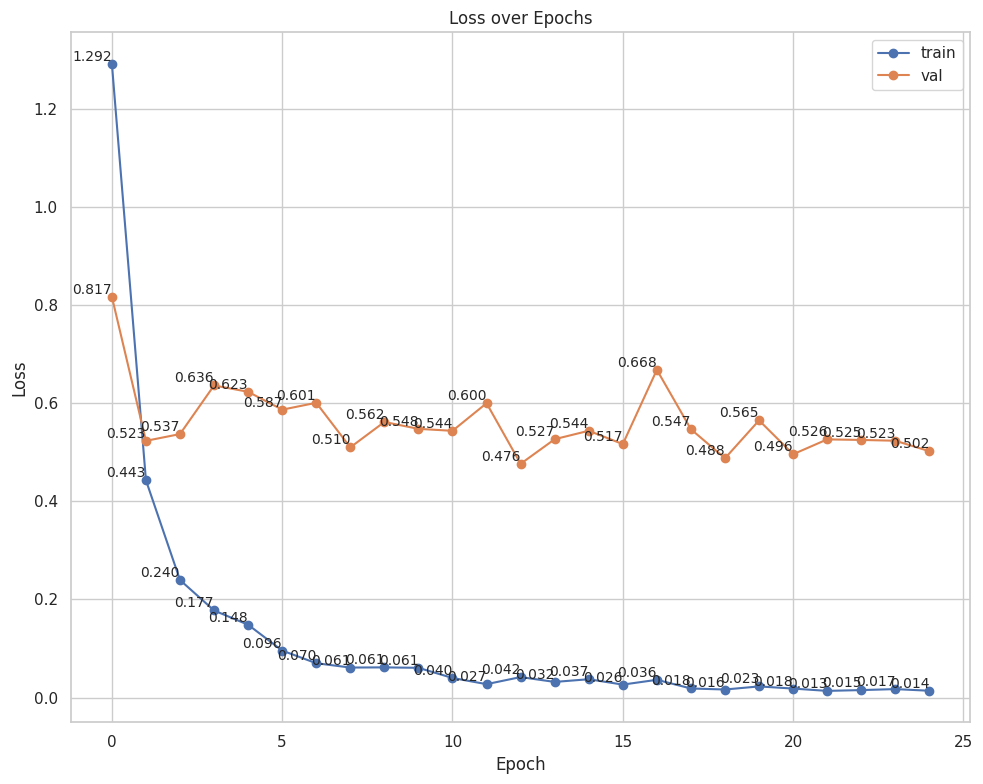

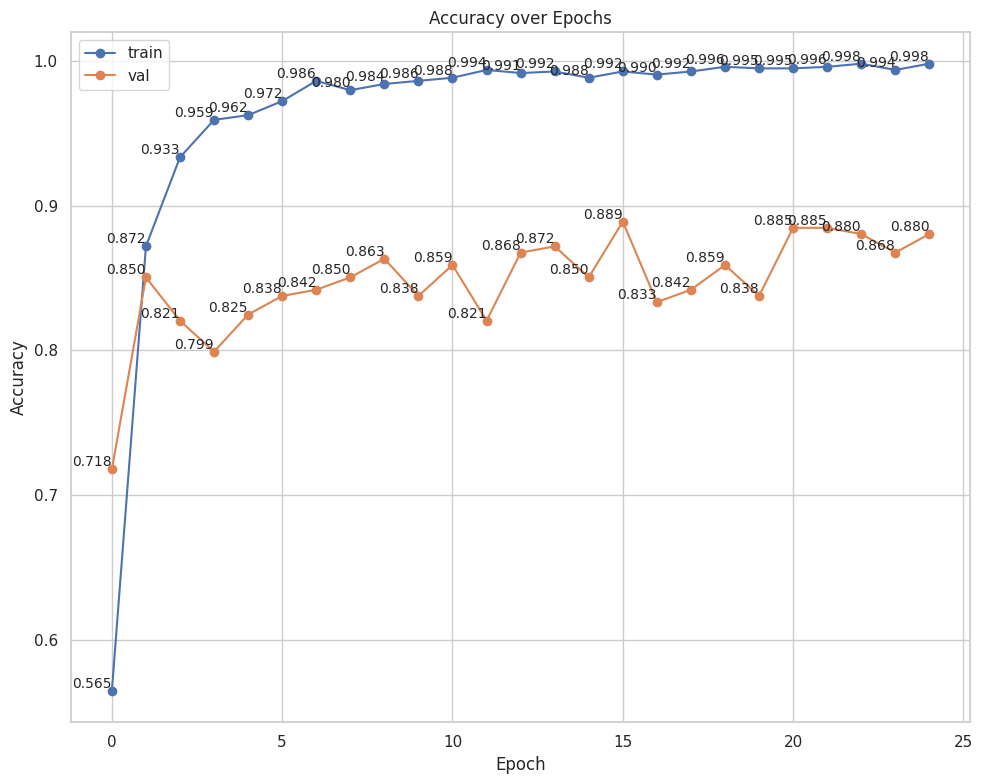

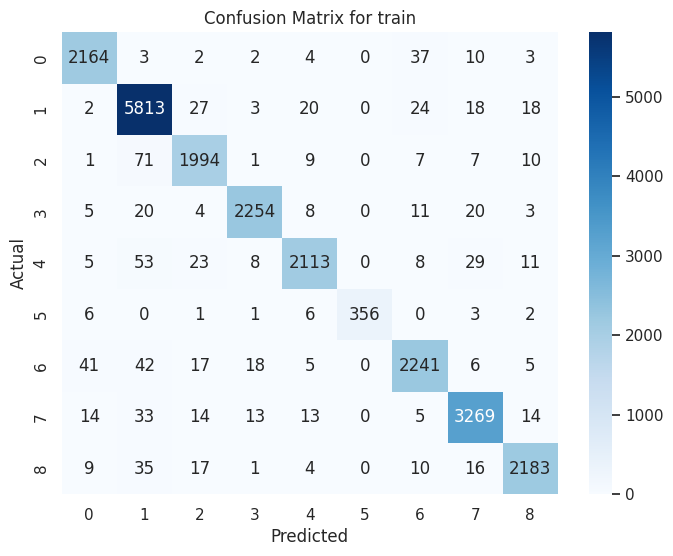

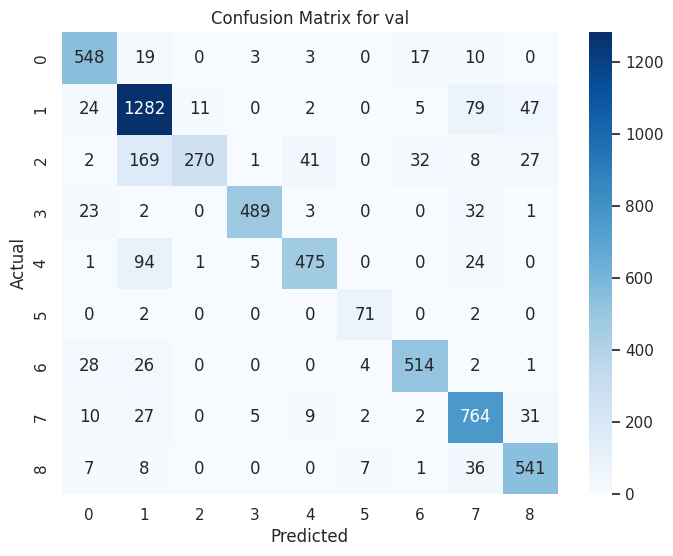

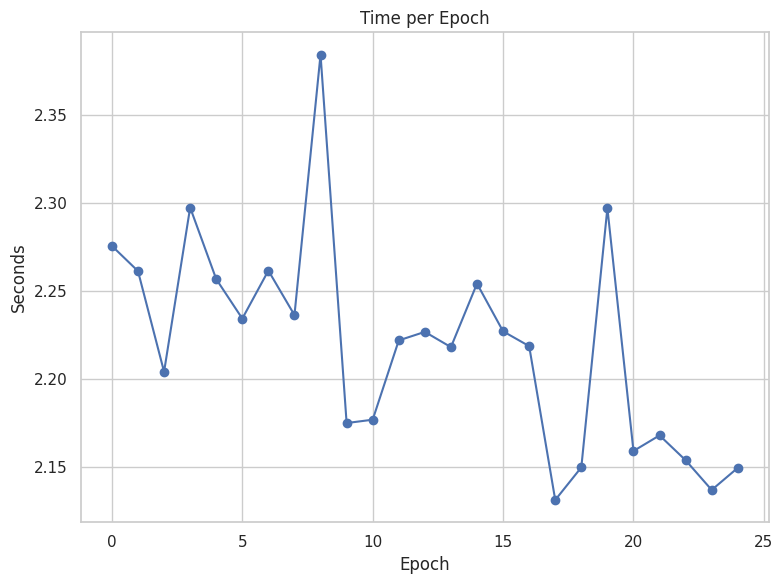

Accuracy of the validation test per label


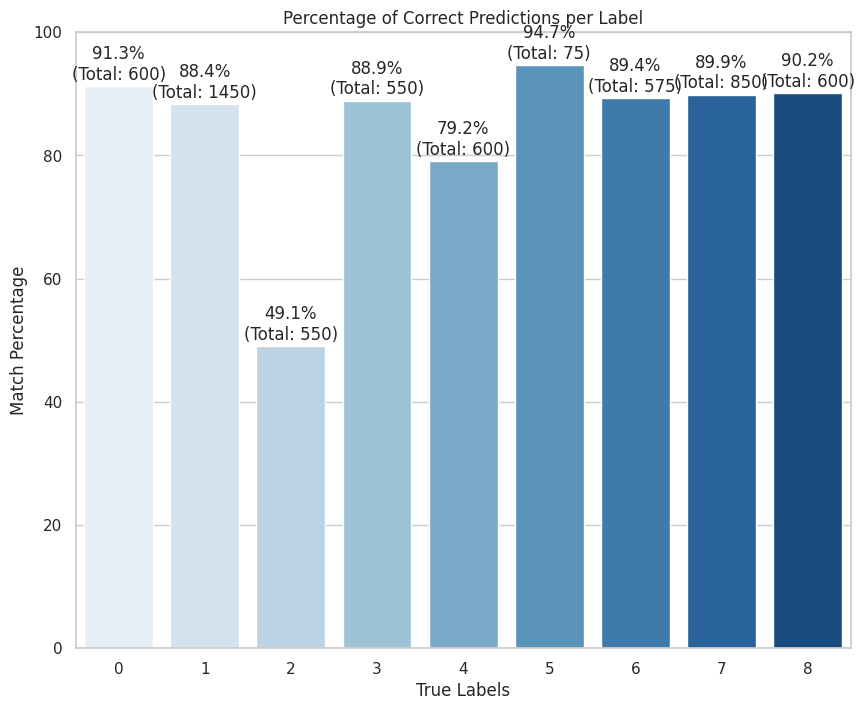

Best val accuracy: tensor(0.8889, device='cuda:0', dtype=torch.float64)


In [52]:
model = models.resnext50_32x4d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)

model, best_acc, validation_labels, probabilities, true_labels = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
    plot_convergence=True,
    plot_epoch_performance=True
)

print("Best val accuracy:", best_acc)


# Fighting overfitting

Our results still show strong overfitting, so let's try to add Dropout and update training for Eraly Stopping

In [67]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def step(self, acc):
        if acc > self.best_acc:
            self.best_acc = acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



In [68]:
def train_model_advanced(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
    patience=5
):
    since = time.time()

    validation_labels = {'train': [], 'val': []}
    probabilities = {'train': [], 'val': []}
    true_labels = {'train': [], 'val': []}
    stored_images = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    early_stop = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    stored_images[phase].append(inputs.cpu())
                    validation_labels[phase].append(preds.cpu())
                    probabilities[phase].append(outputs.detach().cpu())
                    true_labels[phase].append(labels.cpu())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_acc = running_corrects.double().item() / dataset_sizes[phase]
            print(f"{phase} Acc: {epoch_acc:.4f}")

            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                early_stop.step(epoch_acc)

        if early_stop.early_stop:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_wts)

    return (
        model,
        best_acc,
        validation_labels,
        probabilities,
        true_labels,
        stored_images
    )


In [71]:
class ResNeXt50StrongDropout(nn.Module):
    def __init__(self, p=0.6, drop_path_rate=0.1, label_smoothing=0.1):
        super().__init__()

        self.base = models.resnext50_32x4d(pretrained=True)

        num_ftrs = self.base.fc.in_features

        self.classifier = nn.Sequential(
            nn.Dropout(p),
            nn.Linear(num_ftrs, num_ftrs // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(num_ftrs // 2, 9)
        )

        self.drop_path_rate = drop_path_rate
        
        self.criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

        self.base.fc = nn.Identity()

    def forward(self, x, return_features=False):
        feats = self.base(x)

        if self.training and self.drop_path_rate > 0:
            if torch.rand(1).item() < self.drop_path_rate:
                feats = feats * 0 
        logits = self.classifier(feats)
        return logits


In [73]:
criterion = nn.CrossEntropyLoss()

model = ResNeXt50StrongDropout(p=0.3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)
model, best_acc, validation_labels, probabilities, true_labels, stored_images = train_model_advanced(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
    patience=10
)

print("Final best val accuracy:", best_acc)


Epoch 0/24
----------
train Acc: 0.3498
val Acc: 0.6453
Epoch 1/24
----------
train Acc: 0.7255
val Acc: 0.8120
Epoch 2/24
----------
train Acc: 0.7804
val Acc: 0.7692
Epoch 3/24
----------
train Acc: 0.8579
val Acc: 0.8291
Epoch 4/24
----------
train Acc: 0.8611
val Acc: 0.8120
Epoch 5/24
----------
train Acc: 0.9010
val Acc: 0.8120
Epoch 6/24
----------
train Acc: 0.8891
val Acc: 0.8504
Epoch 7/24
----------
train Acc: 0.9074
val Acc: 0.8419
Epoch 8/24
----------
train Acc: 0.8848
val Acc: 0.8333
Epoch 9/24
----------
train Acc: 0.9128
val Acc: 0.8590
Epoch 10/24
----------
train Acc: 0.9429
val Acc: 0.8590
Epoch 11/24
----------
train Acc: 0.8773
val Acc: 0.8675
Epoch 12/24
----------
train Acc: 0.9569
val Acc: 0.8761
Epoch 13/24
----------
train Acc: 0.8730
val Acc: 0.8932
Epoch 14/24
----------
train Acc: 0.9031
val Acc: 0.8889
Epoch 15/24
----------
train Acc: 0.9182
val Acc: 0.8761
Epoch 16/24
----------
train Acc: 0.9225
val Acc: 0.8761
Epoch 17/24
----------
train Acc: 0.9537


# Conclusion
In this project, we built a full transfer-learning pipeline and iteratively improved model performance through systematic experimentation. We began with a **baseline model** that overfitted quickly, which clearly indicated the need for stronger regularization and better augmentation.

We **compared several pretrained architectures** and found that deeper models, particularly ResNeXt50, offered the best generalization. We then **evaluated multiple augmentation strategies** and observed that light geometric transformations improved robustness, while heavy or unrealistic augmentations degraded performance.

Through confusion matrices and high-confidence error analysis, we **identified specific classes** that contributed most to the model’s uncertainty. This allowed us to introduce **targeted augmentation** focused only on the problematic classes, avoiding unnecessary distortion of the entire dataset.

Finally, we added **stronger regularization** — including dropout, label smoothing, and stochastic depth — which reduced overfitting and stabilized validation accuracy.

We managed to increase validation accuracy from about **0.80 → 0.90**. We attribute some of the incorrect guesses to the initial training values containing multiple people while trained for the task to recognize only 1 person